# Setup

In colab:
1. Go to "Runtime" -> "Change runtime type" -> Select "T4 GPU"
2. Install TerraTorch

In [ ]:
# Install required packages in Colab
!pip install git+https://github.com/IBM/terratorch.git
!pip install rioxarray matplotlib
!wget https://raw.githubusercontent.com/IBM/terramind/refs/heads/main/notebooks/plotting_utils.py

In [1]:
import os
import torch
import rioxarray as rxr
import matplotlib.pyplot as plt
from terratorch.registry import FULL_MODEL_REGISTRY
import sys
sys.path.append('../')
from src.utils import plot_s2, plot_modality

# Select device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

/Data/egm/anaconda3/envs/terramind/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
# Build model that generates S-2 L2A (via tokenizer), S-1 GRD, S-1 RTC, DEM, LULC, and NDVI based on raw S-2 L2A input.
# Please note that each output modality requires its own tokenizer which increases the memory requirements
model = FULL_MODEL_REGISTRY.build(
    'terramind_v1_base_generate',
    modalities=['S2L2A'],  # Define the input
    output_modalities=['S1GRD', 'DEM', 'LULC'],  # Define the output from S2L2A, S1GRD, S1RTC, DEM, LULC, and NDVI
    pretrained=True,
    standardize=True,  # If standardize=True, you don't need to do the standardization yourself.
    # offset={'S2L2A': 1000}  # Optional offset in your data. The offset is also applied to the generation. 
)

_ = model.to(device)

# If you need the standardization values, see
from terratorch.models.backbones.terramind.model.terramind_register import v1_pretraining_mean, v1_pretraining_std

In [3]:
# Save the model
torch.save(model, '../models/terramind_v1_base_generate.pth')

In [ ]:
# if os.path.exists('../examples'):
#   # Load local S-2 L2A example paths
#   examples = [
#       '../examples/S2L2A/38D_378R_2_3.tif',
#       '../examples/S2L2A/282D_485L_3_3.tif',
#       '../examples/S2L2A/433D_629L_3_1.tif',
#       '../examples/S2L2A/637U_59R_1_3.tif',
#       '../examples/S2L2A/609U_541L_3_0.tif',
#   ]
# else:
#   # Download examples to Colab
#   !wget -q https://raw.githubusercontent.com/IBM/terramind/refs/heads/main/examples/S2L2A/38D_378R_2_3.tif
#   !wget -q https://raw.githubusercontent.com/IBM/terramind/refs/heads/main/examples/S2L2A/282D_485L_3_3.tif
#   !wget -q https://raw.githubusercontent.com/IBM/terramind/refs/heads/main/examples/S2L2A/433D_629L_3_1.tif
#   !wget -q https://raw.githubusercontent.com/IBM/terramind/refs/heads/main/examples/S2L2A/637U_59R_1_3.tif
#   !wget -q https://raw.githubusercontent.com/IBM/terramind/refs/heads/main/examples/S2L2A/541L_3_0.tif
#   examples = [
#       '38D_378R_2_3.tif',
#       '282D_485L_3_3.tif',
#       '433D_629L_3_1.tif',
#       '637U_59R_1_3.tif',
#       '609U_541L_3_0.tif',
#   ]

In [37]:
# examples = ["/home/egm/Data/Projects/CopGen/data/input/S2L2A/152D_300R.tif"]
examples = ["/home/egm/Data/Projects/CopGen/data/input/S2L2A/152D_300R.tif"]

In [38]:
example_id = 0  # Select id between 0 and 4
# Load an S-2 L2A example
data = rxr.open_rasterio(examples[example_id])
# Convert to shape [B, C, 224, 224]
data = torch.Tensor(data.values, device='cpu').unsqueeze(0)

In [39]:
import torchvision.transforms as T
# Crop to make divisible by 16
def make_divisible_by_16(tensor):
    B, C, H, W = tensor.shape
    new_H = (H // 16) * 16  # 1068 -> 1056
    new_W = (W // 16) * 16  # 1068 -> 1056
    
    # Center crop
    crop = T.CenterCrop((new_H, new_W))
    return crop(tensor)

# Apply cropping
data = make_divisible_by_16(data)
print(f"Cropped data shape: {data.shape}")  # Should be [1, 12, 1056, 1056]

Cropped data shape: torch.Size([1, 12, 1056, 1056])


In [ ]:
# import torchvision.transforms as T
# def crop_to_size(tensor, target_size=256):
#     """Crop tensor to specific size (target_size x target_size)"""
#     crop = T.CenterCrop(target_size)
#     return crop(tensor)

# # Apply cropping to 256x256
# data = crop_to_size(data, target_size=256)
# print(f"Cropped data shape: {data.shape}")  

Cropped data shape: torch.Size([1, 12, 256, 256])


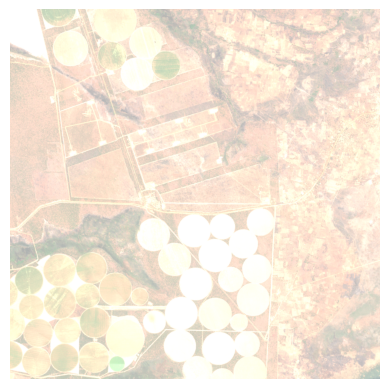

In [40]:
# Visualize S-2 L2A input as RGB
plot_s2(data)

In [31]:
# Run model with diffusion steps
input = data.to(device)
with torch.no_grad():
  generated = model(input, verbose=True, timesteps=10)

100%|██████████| 10/10 [00:00<00:00, 20.61it/s]


In [24]:
def analyze_image(data_input=None, example_id=None):
    """Comprehensive image analysis - accepts either data tensor/xarray or example_id"""
    
    # Handle different input types
    if data_input is not None:
        # If data_input is a torch tensor, we need to convert it back to analyze
        if isinstance(data_input, torch.Tensor):
            # Remove batch dimension if present
            if data_input.dim() == 4:
                data_array = data_input.squeeze(0).cpu().numpy()
            else:
                data_array = data_input.cpu().numpy()
            
            # Create a minimal xarray-like analysis
            print("="*50)
            print(f"ANALYZING TENSOR DATA")
            print("="*50)
            
            print("BASIC INFORMATION:")
            print(f"  Data type: {data_input.dtype}")
            print(f"  Shape (with batch): {data_input.shape}")
            if data_input.dim() == 4:
                print(f"  Shape (C, H, W): {data_input.shape[1:]}")
            
            # Tensor analysis
            print(f"\nTENSOR INFORMATION:")
            print(f"  Tensor shape: {data_input.shape}")
            if data_input.dim() == 4:
                C, H, W = data_input.shape[1], data_input.shape[2], data_input.shape[3]
            else:
                C, H, W = data_input.shape[0], data_input.shape[1], data_input.shape[2]
            
            print(f"  Divisible by 16: H={H%16==0}, W={W%16==0}")
            if H % 16 != 0 or W % 16 != 0:
                new_H = (H // 16) * 16
                new_W = (W // 16) * 16
                print(f"  Suggested crop size: {new_H}x{new_W} (loses {H-new_H}x{W-new_W} pixels)")
            
            return None, data_input
        
        # If data_input is an xarray DataArray
        elif hasattr(data_input, 'values'):
            data_xr = data_input
            file_path = "Direct xarray input"
        else:
            print("Unsupported data type. Please provide torch.Tensor or xarray.DataArray")
            return None, None
            
    elif example_id is not None:
        file_path = examples[example_id]
        data_xr = rxr.open_rasterio(file_path)
    else:
        print("Please provide either data_input or example_id")
        return None, None
    
    # Only run xarray analysis if we have xarray data
    if 'data_xr' in locals():
        print("="*50)
        print(f"ANALYZING: {file_path}")
        print("="*50)
        
        # Basic info
        print("BASIC INFORMATION:")
        if isinstance(file_path, str):
            print(f"  File format: {file_path.split('.')[-1].upper()}")
        print(f"  Shape (bands, height, width): {data_xr.shape}")
        print(f"  Data type: {data_xr.dtype}")
        print(f"  Size: {data_xr.nbytes / 1024**2:.2f} MB")
        
        # Spatial info (only if it's from file)
        if hasattr(data_xr, 'rio') and hasattr(data_xr.rio, 'crs'):
            print("\nSPATIAL INFORMATION:")
            print(f"  CRS: {data_xr.rio.crs}")
            print(f"  Bounds: {data_xr.rio.bounds()}")
            print(f"  Resolution (x, y): {data_xr.rio.resolution()}")
            print(f"  Transform: {data_xr.rio.transform()}")
            
            # Data characteristics
            print("\nDATA CHARACTERISTICS:")
            print(f"  NoData value: {data_xr.rio.nodata}")
            print(f"  Number of bands: {data_xr.rio.count}")
        
        print(f"  Band names/numbers: {list(data_xr.band.values) if 'band' in data_xr.dims else 'N/A'}")
        
        # Value statistics
        print(f"\nVALUE STATISTICS:")
        print(f"  Overall min: {float(data_xr.min().values):.4f}")
        print(f"  Overall max: {float(data_xr.max().values):.4f}")
        print(f"  Overall mean: {float(data_xr.mean().values):.4f}")
        print(f"  Overall std: {float(data_xr.std().values):.4f}")
        
        # Check for special values
        nan_count = int(torch.isnan(torch.tensor(data_xr.values)).sum())
        inf_count = int(torch.isinf(torch.tensor(data_xr.values)).sum())
        print(f"  NaN values: {nan_count}")
        print(f"  Infinite values: {inf_count}")
        
        # Per-band analysis
        print(f"\nPER-BAND ANALYSIS:")
        if 'band' in data_xr.dims:
            for i, band in enumerate(data_xr.band.values):
                band_data = data_xr.sel(band=band)
                print(f"  Band {i+1:2d}: min={float(band_data.min().values):8.2f}, "
                      f"max={float(band_data.max().values):8.2f}, "
                      f"mean={float(band_data.mean().values):8.2f}, "
                      f"std={float(band_data.std().values):8.2f}")
        else:
            # Handle case where there are no explicit band dimensions
            if data_xr.ndim == 3:
                for i in range(data_xr.shape[0]):
                    band_data = data_xr[i]
                    print(f"  Channel {i+1:2d}: min={float(band_data.min().values):8.2f}, "
                          f"max={float(band_data.max().values):8.2f}, "
                          f"mean={float(band_data.mean().values):8.2f}, "
                          f"std={float(band_data.std().values):8.2f}")
        
        # Convert to tensor and check divisibility
        data_tensor = torch.Tensor(data_xr.values).unsqueeze(0)
        B, C, H, W = data_tensor.shape
        print(f"\nTENSOR INFORMATION:")
        print(f"  Tensor shape: {data_tensor.shape}")
        print(f"  Divisible by 16: H={H%16==0}, W={W%16==0}")
        if H % 16 != 0 or W % 16 != 0:
            new_H = (H // 16) * 16
            new_W = (W // 16) * 16
            print(f"  Suggested crop size: {new_H}x{new_W} (loses {H-new_H}x{W-new_W} pixels)")
        
        return data_xr, data_tensor

# Now you can use either:
# analyze_image(data)  # Pass your data directly
# # or
analyze_image(example_id=0)  # Use example_id as before

ANALYZING: /home/egm/Data/Projects/CopGen/data/input/S2L2A/92U_5R.tif
BASIC INFORMATION:
  File format: TIF
  Shape (bands, height, width): (12, 1068, 1068)
  Data type: uint16
  Size: 26.11 MB

SPATIAL INFORMATION:
  CRS: EPSG:32631
  Bounds: (219171.17468699333, 913981.5691860078, 229851.17468699333, 924661.5691860078)
  Resolution (x, y): (10.0, -10.0)
  Transform: | 10.00, 0.00, 219171.17|
| 0.00,-10.00, 924661.57|
| 0.00, 0.00, 1.00|

DATA CHARACTERISTICS:
  NoData value: None
  Number of bands: 12
  Band names/numbers: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

VALUE STATISTICS:
  Overall min: 207.0000
  Overall max: 15261.0000
  Overall mean: 1545.3960
  Overall std: 798.5543
  NaN values: 0
  Infinite values: 0

PER-BAND ANALYSIS:
  Band  1: min=  248.00, max=  938.00, mean=  421.49, std=   70.93
  Band  2: min=  207.00, max= 6356.00, mean=  485.54, std=  108.91
  Band  3: min=  322.00, max= 4644.00, mean=  708.28, std=  138.26
  Band  4: min=  252.00, max= 7184.00, mean=  822.78

(<xarray.DataArray (band: 12, y: 1068, x: 1068)> Size: 27MB
 array([[[ 443,  443, ...,  482,  482],
         [ 443,  443, ...,  482,  482],
         ...,
         [ 363,  363, ...,  356,  356],
         [ 363,  363, ...,  356,  356]],
 
        [[ 452,  472, ...,  547,  552],
         [ 417,  416, ...,  524,  520],
         ...,
         [ 316,  357, ...,  385,  400],
         [ 350,  359, ...,  368,  369]],
 
        ...,
 
        [[2368, 2368, ..., 2018, 2018],
         [2368, 2368, ..., 2018, 2018],
         ...,
         [1840, 1840, ..., 2086, 2086],
         [1840, 1840, ..., 2086, 2086]],
 
        [[1284, 1284, ..., 1110, 1110],
         [1284, 1284, ..., 1110, 1110],
         ...,
         [1022, 1022, ..., 1196, 1196],
         [1022, 1022, ..., 1196, 1196]]], dtype=uint16)
 Coordinates:
   * band         (band) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
   * x            (x) float64 9kB 2.192e+05 2.192e+05 ... 2.298e+05 2.298e+05
   * y            (y) float64 9kB 9.247e+05 9.246e

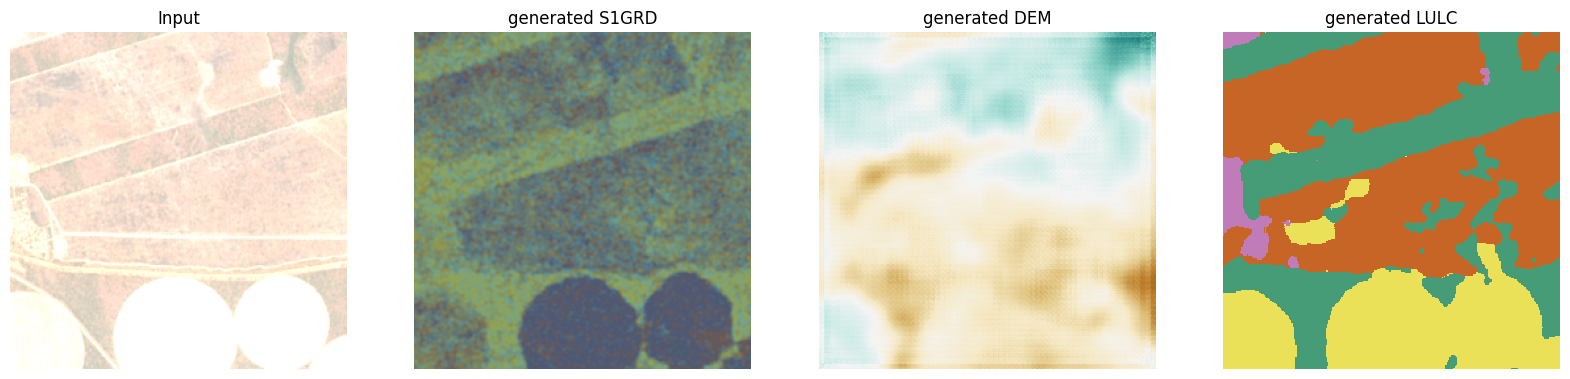

In [32]:
# Plot generations
n_plots = len(generated) + 1
fig, ax = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5))

plot_s2(input, ax=ax[0])
ax[0].set_title('Input')

for i, (mod, value) in enumerate(generated.items()):
    plot_modality(mod, value, ax=ax[i + 1])

    ax[i+1].set_title('generated ' + mod)
    
plt.show()